### Human Settlement

In [1]:
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

import lightgbm as lgb

from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

In [2]:
id_map = pd.read_csv("/kaggle/input/human-settlement/inegi-gcim-human-settlement-detection-challenge20240902-4068-16grepu/id_map.csv")
sub = pd.read_csv("/kaggle/input/human-settlement/inegi-gcim-human-settlement-detection-challenge20240902-4068-16grepu/SampleSubmission.csv")
display(id_map.head(), sub.head())

,id,ID
0,id_xjoh8datmz,0
1,id_ui7ciy2r2l,1
2,id_le7254d4ch,2
3,id_99qf1p6vg0,3
4,id_jc5kg2grpc,4


,id,class
0,id_f5l6neabz0,0
1,id_7u688i5j5v,0
2,id_wm2bkde80r,0
3,id_0e6spuo284,0
4,id_dm71xazj94,0


### Config

In [3]:
class Config:
    patches = True
    if patches:
        num_patches = 10
    model_name = "lgb"
    model_type = "gbdt"
    
    n_splits = 5
CFG = Config()

### Data Preparation

In [4]:

class LoadTransformExport:
    def __init__(self):
        self.scaler = None

    def load_data(self):
        # Open the HDF5 files with memory mapping
        trainset = h5py.File("/kaggle/input/human-settlement/train_data-001.h5", "r")
        testset = h5py.File("/kaggle/input/human-settlement/test_data.h5", "r")
        return trainset, testset

    def to_array(self, data, mode="train"):
        # Use float32 instead of float64 for memory efficiency
        data_images = np.array(data['images'], dtype=np.float32)
        data_images = data_images.transpose(0, 3, 1, 2)
        if mode == "train":
            # Use int8 if label range allows it, otherwise int32
            data_labels = np.array(data['labels'], dtype=np.int8)
            return data_images, data_labels
        else:
            return data_images

    def patch_img(self, images, patch_size=7):
        num_samples, num_channels, img_height, img_width = images.shape
        # Calculate the coordinates of the patch center
        center_row, center_col = img_height // 2, img_width // 2
        # Extract the patch from the center of each image
        patch_array = images[:, :,
                             center_row-patch_size//2:center_row+patch_size//2+1,
                             center_col-patch_size//2:center_col+patch_size//2+1]
        # Flatten the patches
        patch_array_flattened = patch_array.reshape(num_samples, -1)
        return patch_array_flattened
    def sample_data(self, images, labels, n_samples=150000):
            # Separate the majority and minority classes
            majority_class = images[labels == 0]
            minority_class = images[labels == 1]

            # Undersample majority class
            majority_undersampled = resample(majority_class,
                                             replace=False,    # Sample without replacement
                                             n_samples=n_samples, # To match minority class size
                                             random_state=42)  # For reproducibility

            # Combine minority class with undersampled majority class
            balanced_images = np.vstack((majority_undersampled, minority_class))
            balanced_labels = np.concatenate((np.zeros(n_samples), np.ones(len(minority_class))))

            return balanced_images, balanced_labels

    def calculate_spectral_indices(self, data):
        blue, green, red, nir, swir1, swir2 = np.split(data, 6, axis=1)
        epsilon = 1e-8  # Small value to avoid division by zero

        # Existing indices
        ndvi = (nir - red) / (nir + red + epsilon)
        evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1 + epsilon))
        ndwi = (green - nir) / (green + nir + epsilon)
        ndbi = (swir1 - nir) / (swir1 + nir + epsilon)
        L = 0.5
        savi = ((nir - red) / (nir + red + L + epsilon)) * (1 + L)
        nbr = (nir - swir2) / (nir + swir2 + epsilon)
        evi2 = 2.5 * ((nir - red) / (nir + 2.4 * red + 1 + epsilon))
        msavi = (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red))) / 2
        sr = nir / (red + epsilon)
        gci = (nir / (green + epsilon)) - 1
        sipi = (nir - blue) / (nir - red + epsilon)
        cwi = (green * swir1) / (nir**2 + epsilon)
        msi = swir1 / nir
        nmdi = (nir - (swir1 - swir2)) / (nir + (swir1 - swir2) + epsilon)
        ri = red / green
        gli = (2 * green - red - blue) / (2 * green + red + blue + epsilon)
        blue_green_ratio = blue / (green + epsilon)
        green_red_ratio = green / (red + epsilon)

        ndi45 = (red - blue) / (red + blue + epsilon)  # Normalized Difference Index (45)
        si = (blue + green + red) / 3  # Saturation Index

        return np.column_stack((ndvi, evi, ndwi, ndbi, savi,nbr,evi2, msavi,
                                sr, gci, sipi, cwi, msi, nmdi, ri, gli, blue_green_ratio,
                                green_red_ratio, si, ndi45))
    def handle_invalid_values(self, data):
       # Replace inf with large finite numbers
        data = np.nan_to_num(data, nan=0.0, posinf=1e30, neginf=-1e30)
        return data


    def preprocess(self, data, fit_scaler=True):
        data = data.reshape(data.shape[0], -1)
        data = self.handle_invalid_values(data)  # Add this line
        if self.scaler is None or fit_scaler:
            self.scaler = RobustScaler()
            data = self.scaler.fit_transform(data)
        else:
            data = self.scaler.transform(data)
        return data

    def engineer_features(self, data, patch_size=7, include_spectral_indices=True):
        # Extract patches
        patched_data = self.patch_img(data, patch_size)

        features = [patched_data]

        # Calculate spectral indices if requested
        if include_spectral_indices:
            spectral_indices = self.calculate_spectral_indices(patched_data)
            features.append(spectral_indices)

        # Combine all features
        all_features = np.hstack(features)

        return all_features

    def process_data(self, mode="train", patch_size=7, include_spectral_indices=True, sample_size=150000):
        # Load data
        trainset, testset = self.load_data()

        if mode == "train":
            # Process training data
            train_images, train_labels = self.to_array(trainset, mode="train")

            # Sample the data
            train_images, train_labels = self.sample_data(train_images, train_labels, n_samples=sample_size)

            train_features = self.engineer_features(train_images, patch_size, include_spectral_indices)
            processed_train = self.preprocess(train_features, fit_scaler=True)
            del train_images, train_features
            return processed_train, train_labels
        else:
            # Process test data
            test_images = self.to_array(testset, mode="test")
            test_features = self.engineer_features(test_images, patch_size, include_spectral_indices)
            processed_test = self.preprocess(test_features, fit_scaler=False)
            del test_images, test_features
            return processed_test

# Create an instance of the class
datamanager = LoadTransformExport()

# Process train data with sampling
train_images, train_labels = datamanager.process_data(mode="train", patch_size=CFG.num_patches, include_spectral_indices=True, sample_size=150000)

# Process test data without sampling
test_images = datamanager.process_data(mode="test", patch_size=CFG.num_patches, include_spectral_indices=True)


In [5]:

# Assuming train_labels is a numpy array
unique_labels, counts = np.unique(train_labels, return_counts=True)

# Creating a dictionary for easy interpretation
label_distribution = dict(zip(unique_labels, counts))

print(label_distribution)


{0.0: 150000, 1.0: 100000}


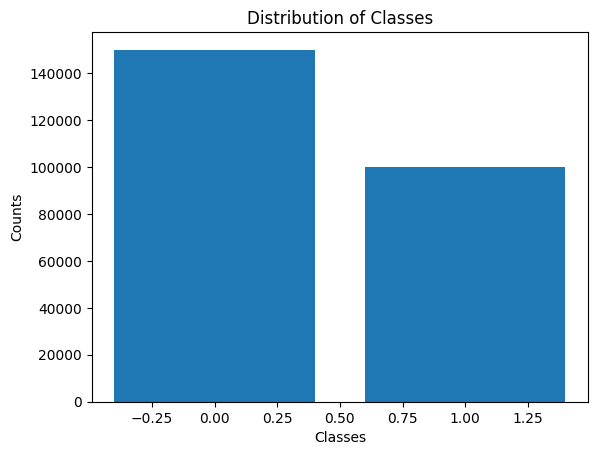

In [6]:
# Plotting
plt.bar(unique_labels, counts)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribution of Classes')
plt.show()

### Model Training

In [7]:
lgb_params = {'max_depth': 20, 'learning_rate': 0.042349789445541686, 'subsample': 0.7958327935295937, 'num_leaves': 253, 'colsample_bytree': 0.6527432815702722, 'reg_lambda': 0.2734976598211545, 'reg_alpha': 2.350737147421974, 'min_child_samples': 75, 'min_child_weight': 0.00148926783409545, 'boosting_type': 'gbdt', 'cat_smooth': 14, 'cat_l2': 10}
lgb_params_2 = {'max_depth': 61, 'learning_rate': 0.050889715273411885, 'subsample': 0.839710105640511, 'num_leaves': 119, 'colsample_bytree': 0.9505368414600647, 'reg_lambda': 0.001436910705942445, 'reg_alpha': 4.633470025453989, 'min_child_samples': 68, 'min_child_weight': 4.760405719744953, 'boosting_type': 'gbdt', 'cat_smooth': 69, 'cat_l2': 20}
cat_params = {'depth': 5, 'learning_rate': 0.16172153851818008, 'l2_leaf_reg': 0.0016223011291958628, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9928280196089001}
class Trainer:
    def define_model(self, model_name='catt'):
        if model_name == 'catt':
            return catt.CatBoostClassifier(
                iterations= 1000,
                task_type= 'GPU',
                eval_metric = 'AUC',
                verbose =  250,
                random_state = 42,
                **cat_params
            )
        elif model_name == 'lgb':
            return lgb.LGBMClassifier(
                metric ='AUC',
                device =  'gpu',
                n_jobs= -1,
                n_estimators = 5000,
                verbosity = -1,
                max_bins = 63,
                random_state = 42,
                **lgb_params_2
                
            )
        elif model_name == 'xgb':
            return xgb.XGBClassifier(eval_metric='auc',
                             n_estimators=10000,
                             learning_rate=0.01,
                             seed=162,
                             random_state=162,
                             colsample_bytree=0.65,
                             tree_method="gpu_hist",
                             predictor="gpu_predictor",
                             early_stopping_rounds=100,
                             n_jobs=-1,
                             )
        elif model_name =='stacking':
            pass
        
    def cross_val(self, k =5):
        return StratifiedKFold(n_splits = k, shuffle=True, random_state=162)
    

    def train_K_folds(self, train_data, y, sub_data, model_name, model_type, k = 5):
        kf = self.cross_val(k)
        oof_predictions = np.zeros(len(train_data))
        sub_predictions = []
        cv_score = 0
        
        for i, (tr_index, test_index) in enumerate(kf.split(train_data, y)):
            X_train,y_train = train_data[tr_index,:],y[tr_index]
            X_test,y_test = train_data[test_index,:],y[test_index]

            print()
            print(f'######### FOLD {i+1} / {kf.n_splits} ')

            model = self.define_model(model_name)
            if model_type =='gbdt' and model_name not in ['lgb']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose = 1000)
            elif model_type =='gbdt' and model_name in ['lgb']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
            else:
                model.fit(X_train, y_train)

            # Validation
            y_test_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
            cv_score_ = roc_auc_score(y_test, y_test_probs)
            oof_predictions[test_index] = y_test_probs
            print(f"fold {i+1}/{k} AUC_score : {cv_score_}")

            # Submission
            sub_data_probs = model.predict_proba(sub_data)[:, 1]  # Get probabilities for the positive class

            sub_predictions.append(sub_data_probs)
        return oof_predictions, np.mean(sub_predictions,0)

In [8]:
len(train_images)

250000

In [9]:
trainer = Trainer()
oof_predictions,sub_predictions = trainer.train_K_folds(train_data=train_images,
                                                        y= train_labels,
                                                        sub_data=test_images,
                                                        model_name=CFG.model_name,
                                                        model_type=CFG.model_type,
                                                        k=CFG.n_splits,
                                                        )


######### FOLD 1 / 5 


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


fold 1/5 AUC_score : 0.8796183333333334

######### FOLD 2 / 5 
fold 2/5 AUC_score : 0.8806235866666667

######### FOLD 3 / 5 
fold 3/5 AUC_score : 0.8797302816666667

######### FOLD 4 / 5 
fold 4/5 AUC_score : 0.8780521083333335

######### FOLD 5 / 5 
fold 5/5 AUC_score : 0.8809889966666667


In [10]:

pred = pd.DataFrame({'Target':abs(sub_predictions)}).rename_axis('ID').reset_index()
pred = id_map.merge(pred, on='ID').drop(columns=['ID'])
pred.head()

,id,Target
0,id_xjoh8datmz,0.232901
1,id_ui7ciy2r2l,0.027773
2,id_le7254d4ch,0.015221
3,id_99qf1p6vg0,0.009978
4,id_jc5kg2grpc,0.062926


In [11]:
pred.to_csv('lgb_submission.csv', index=False)
pred.describe()

,Target
count,120000.000000
mean,0.426428
std,0.374805
min,0.000002
25%,0.041499
50%,0.345848
75%,0.822023
max,0.999971
